In [4]:
import sys
import os
import pickle
from collections import Counter
from itertools import combinations

import random
import glob
import scipy.stats as stats

import networkx as nx
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn import cluster,metrics
from sklearn.preprocessing import StandardScaler, Normalizer
from s_dbw import S_Dbw
%matplotlib inline

ModuleNotFoundError: No module named 's_dbw'

In [ ]:
with open("../data/processed/disease_ontograph.pkl", 'rb') as f:
    disease_ontograph = pickle.load(f)
    #Remove unconnected components
components = [i for i in nx.connected_components(disease_ontograph)]
disease_ontograph = disease_ontograph.subgraph(components[0]).copy()

diseases = [n for n in disease_ontograph.nodes if disease_ontograph.nodes[n].get('label') ==  'disease']

In [ ]:
model_files = glob.glob("../data/clusters/kmeans/*.pkl")

In [ ]:
m_file = model_files[0]
m_pars = os.path.splitext(m_file)[0].split("_")
print(m_file)

In [ ]:
N = m_pars[2][1:]
L = m_pars[3][1:]
D = m_pars[4][1:]
K_dim = m_pars[5][1:]
MODEL = m_pars[6]
K_kmean = m_pars[7][4:]


In [2]:
embedding_file = "../data/embeddings/ontograph_embed_N{0}_L{1}_D{2}_K{3}.model".format(N,L,D,K_dim)
model = Word2Vec.load(embedding_file)
disease_vectors = model.wv[diseases]
standard_vectors = StandardScaler().fit_transform(disease_vectors)
normalized_vectors = Normalizer().fit_transform(standard_vectors)

NameError: name 'N' is not defined

In [3]:
with open(m_file, 'rb') as f:
    cluster_model = pickle.load(f)

NameError: name 'm_file' is not defined

In [8]:
labels = cluster_model.labels_
X = disease_vectors

In [9]:
def scatter_crit(X,labels):
    u = np.mean(X,axis=0)
    for k in set(labels):
        Nk = sum(labels == k)
        uk = np.mean(X[labels == k],axis=0)
        if k == 0:
            Sw = np.cov(X[labels == k],rowvar=False)*(Nk-1)
            Sb = Nk*np.outer(uk-u,uk-u)
        else:
            Sw += np.cov(X[labels == k],rowvar=False)*(Nk-1)
            Sb += Nk*np.outer(uk-u,uk-u)
        

    return np.trace(np.matmul(np.linalg.inv(Sw),Sb)) 

In [12]:
scatter_crit(normalized_vectors,labels)

18.717652512092624

In [16]:
N = 70
L = 175
K_dim = 16
MODEL = 'KMEANS'
#D = 256 #[8,14,16,18,20,24,32,64,128,256]
L = 50 #[50,75,100,125,150,175]
inv_crit = []
for D in [8,14,16,18,20,24,32,64,128,256]:
    model_files = glob.glob("../data/clusters/kmeans/ontograph_embed_N{0}_L{1}_D{2}_K{3}_KMEANS*.pkl".format(N,L,D,K_dim))
    embedding_file = "../data/embeddings/ontograph_embed_N{0}_L{1}_D{2}_K{3}.model".format(N,L,D,K_dim)
    model = Word2Vec.load(embedding_file)
    disease_vectors = model.wv[diseases]
    standard_vectors = StandardScaler().fit_transform(disease_vectors)
    normalized_vectors = Normalizer().fit_transform(standard_vectors)
    
    with open(model_files[0], 'rb') as f:
        cluster_model = pickle.load(f)
    
    inv_crit.append(scatter_crit(normalized_vectors,cluster_model.labels_))

In [17]:
inv_crit

[21.27661457188048,
 18.737796086671832,
 19.460848566117136,
 20.0853203342935,
 20.481566349060554,
 21.066815571950755,
 23.56403682177496,
 32.17103399311613,
 38.153336778500126,
 44.83729712697074]

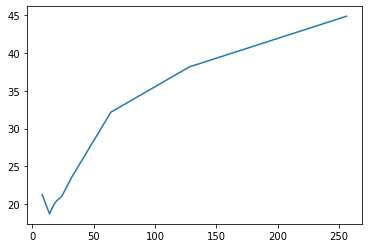

In [18]:
plt.plot([8,14,16,18,20,24,32,64,128,256],inv_crit)

In [26]:
model_files

['../data/clusters/kmeans/ontograph_embed_N70_L50_D256_K16_KMEANS_KOPT37.pkl']

### Loop over all cluster models

In [ ]:
model_evals = []
model_files = glob.glob("../data/clusters/kmeans/*.pkl")

In [ ]:
i=927
for m_file in model_files[i:]:
    m_pars = os.path.splitext(m_file)[0].split("_")
    N = m_pars[2][1:]
    L = m_pars[3][1:]
    D = m_pars[4][1:]
    K_dim = m_pars[5][1:]
    MODEL = m_pars[6]
    K_kmean = m_pars[7][4:]
    
    embedding_file = "../data/embeddings/ontograph_embed_N{0}_L{1}_D{2}_K{3}.model".format(N,L,D,K_dim)
    model = Word2Vec.load(embedding_file)
    disease_vectors = model.wv[diseases]
    standard_vectors = StandardScaler().fit_transform(disease_vectors)
    normalized_vectors = Normalizer().fit_transform(standard_vectors)
    
    
    with open(m_file, 'rb') as f:
        cluster_model = pickle.load(f)
        
    mdata = {}
    mdata['N_WALKS'] = int(N)
    mdata['L_WALKS'] = int(L)
    mdata['D_EMBED'] = int(D)
    mdata['K_DIM']   = int(K_dim)
    mdata['Model']   = MODEL
    mdata['K_clust'] = int(K_kmean)
    
    mdata['silhouette_euclidean'] = metrics.silhouette_score(normalized_vectors, cluster_model.labels_, metric='euclidean')
    mdata['davies_bouldin'] = metrics.davies_bouldin_score(normalized_vectors, cluster_model.labels_)
    mdata['calinski_harabasz'] = metrics.calinski_harabasz_score(normalized_vectors, cluster_model.labels_)
    mdata['scattering_criteria'] = scatter_crit(normalized_vectors,cluster_model.labels_)
    
    model_evals.append(mdata)
    print(i)
    i+=1

927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098


## Evaluation

In [ ]:
model_eval_df = pd.DataFrame(model_evals)
model_eval_df.to_csv("../data/processed/kmeans_model_metrics.csv",index=False)

In [ ]:
model_eval_df

In [ ]:
model_eval_df.describe()

In [ ]:
metric_rank_mat = pd.concat([model_eval_df['silhouette_euclidean'].rank(ascending=False), #High values == low rank
model_eval_df['davies_bouldin'].rank(), #Low values == low rank
model_eval_df['calinski_harabasz'].rank(ascending=False),
model_eval_df['scattering_criteria'].rank(ascending=False)]

In [ ]:
metric_rank_mat.corr(method='spearman')

In [26]:
model_eval_df['mean_ranks'] = metric_rank_mat.mean(axis=1)

In [27]:
model_eval_df.sort_values(by='mean_ranks').head(n=10)

,N_WALKS,L_WALKS,D_EMBED,K_DIM,Model,K_clust,silhouette_euclidean,silhouette_cosine,davies_bouldin,calinski_harabasz,sdbw_euclidean,sdbw_cosine,mean_ranks
794,40,150,2,12,KMEANS,22,0.567749,0.725379,0.484737,130454.474348,0.056264,0.056264,6.166667
147,50,150,2,8,KMEANS,22,0.570998,0.721375,0.499054,157013.734791,0.061204,0.061204,13.666667
95,40,125,2,14,KMEANS,21,0.570584,0.731384,0.496121,113568.429966,0.059941,0.059941,14.333333
700,30,125,2,8,KMEANS,22,0.557746,0.715977,0.494259,150160.336328,0.060162,0.060162,14.750000
493,30,150,2,10,KMEANS,22,0.564425,0.718611,0.492169,167100.072024,0.062602,0.062602,17.333333
382,20,75,2,10,KMEANS,22,0.562083,0.722245,0.506746,132652.639137,0.060144,0.060144,19.166667
391,10,100,2,12,KMEANS,22,0.557746,0.717066,0.506294,136973.640947,0.058502,0.058502,19.250000
345,40,50,2,10,KMEANS,21,0.560608,0.718879,0.494619,81848.723928,0.059065,0.059065,20.000000
828,20,50,2,12,KMEANS,22,0.556487,0.717145,0.508065,121263.257331,0.056898,0.056898,22.666667
267,50,75,2,8,KMEANS,21,0.570943,0.730538,0.500814,145333.484370,0.063733,0.063733,23.833333


In [31]:
model_eval_df.groupby(['D_EMBED','N_WALKS']).silhouette_euclidean.agg('mean')

D_EMBED  N_WALKS
2        5          0.547426
         10         0.546020
         20         0.548091
         30         0.551939
         40         0.548420
         50         0.549364
4        5          0.296718
         10         0.296505
         20         0.295951
         30         0.299224
         40         0.301037
         50         0.301029
8        5          0.161347
         10         0.164098
         20         0.166905
         30         0.167651
         40         0.169704
         50         0.170538
16       5          0.111646
         10         0.111634
         20         0.113293
         30         0.115840
         40         0.115680
         50         0.116691
32       5          0.077882
         10         0.075870
         20         0.080188
         30         0.083753
         40         0.085336
         50         0.085770
64       5          0.047942
         10         0.049069
         20         0.053092
         30         0.0548

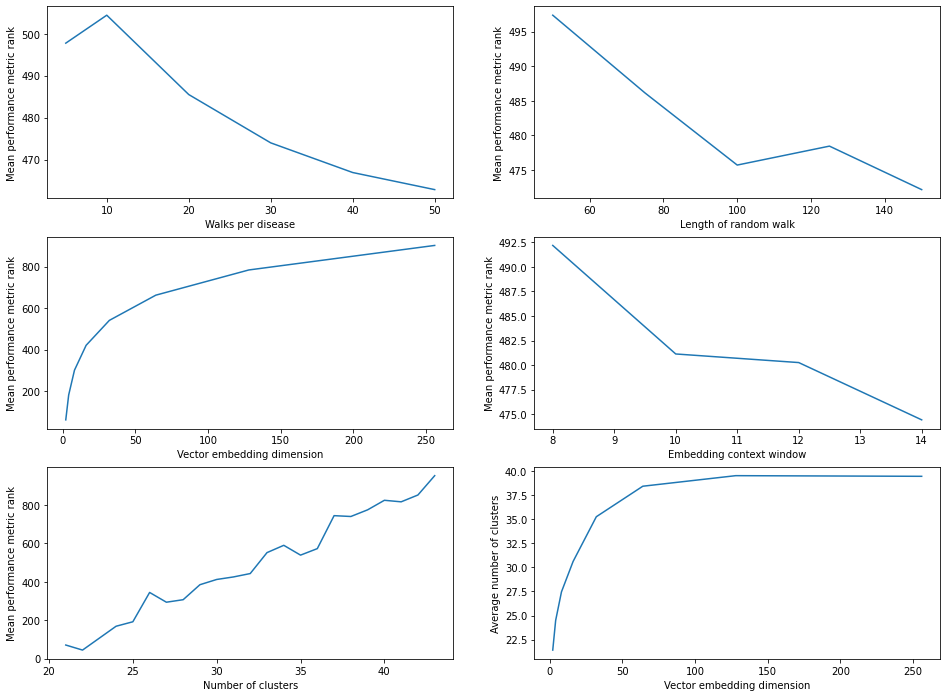

In [28]:
fig = plt.figure(figsize=(16, 12), facecolor='w', edgecolor='k')

plt.subplot(3,2,1)
plt.plot(model_eval_df.groupby('N_WALKS').mean_ranks.agg('mean'))
plt.ylabel("Mean performance metric rank")
plt.xlabel("Walks per disease")


plt.subplot(3,2,2)
plt.plot(model_eval_df.groupby('L_WALKS').mean_ranks.agg('mean'))
plt.ylabel("Mean performance metric rank")
plt.xlabel("Length of random walk")


plt.subplot(3,2,3)
plt.plot(model_eval_df.groupby('D_EMBED').mean_ranks.agg('mean'))
plt.ylabel("Mean performance metric rank")
plt.xlabel("Vector embedding dimension")


plt.subplot(3,2,4)
plt.plot(model_eval_df.groupby('K_DIM').mean_ranks.agg('mean'))
plt.ylabel("Mean performance metric rank")
plt.xlabel("Embedding context window")

plt.subplot(3,2,5)
plt.plot(model_eval_df.groupby('K_clust').mean_ranks.agg('mean'))
plt.ylabel("Mean performance metric rank")
plt.xlabel("Number of clusters")


plt.subplot(3,2,6)
plt.plot(model_eval_df.groupby('D_EMBED').K_clust.agg('mean'))
plt.ylabel("Average number of clusters")
plt.xlabel("Vector embedding dimension")


plt.show()

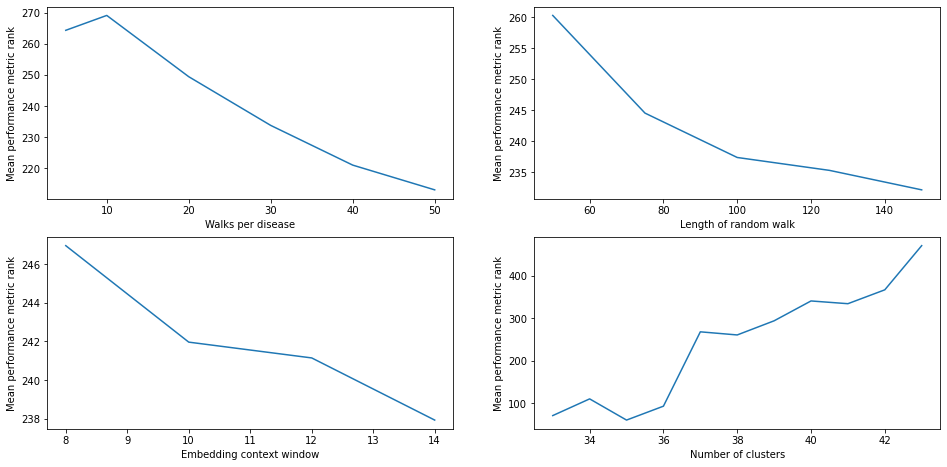

In [83]:
fig = plt.figure(figsize=(16, 12), facecolor='w', edgecolor='k')

plt.subplot(3,2,1)
plt.plot(model_eval_df.groupby('N_WALKS').mean_ranks.agg('mean'))
plt.ylabel("Mean performance metric rank")
plt.xlabel("Walks per disease")

plt.subplot(3,2,2)
plt.plot(model_eval_df.groupby('L_WALKS').mean_ranks.agg('mean'))
plt.ylabel("Mean performance metric rank")
plt.xlabel("Length of random walk")

plt.subplot(3,2,3)
plt.plot(model_eval_df.groupby('K_DIM').mean_ranks.agg('mean'))
plt.ylabel("Mean performance metric rank")
plt.xlabel("Embedding context window")

plt.subplot(3,2,4)
plt.plot(model_eval_df.groupby('K_clust').mean_ranks.agg('mean'))
plt.ylabel("Mean performance metric rank")
plt.xlabel("Number of clusters")



plt.show()

,N_WALKS,L_WALKS,D_EMBED,K_DIM,K_clust,silhouette_euclidean,silhouette_cosine,silhouette_mutual_prox,davies_bouldin,calinski_harabasz,sdbw_euclidean,sdbw_cosine,mean_ranks
count,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000
mean,25.714286,99.792961,119.320911,11.006211,38.136646,0.047436,0.086330,0.315909,3.712432,38.867779,0.850114,0.850114,242.000000
std,15.950427,35.464590,85.556044,2.240231,2.096718,0.023308,0.040769,0.075607,0.913848,21.597068,0.053436,0.053436,138.425359
min,5.000000,50.000000,32.000000,8.000000,33.000000,0.015826,0.030121,0.155764,2.325875,13.404406,0.747484,0.747484,1.714286
25%,10.000000,75.000000,48.000000,9.000000,36.000000,0.027796,0.052221,0.258473,2.852898,21.743224,0.805070,0.805070,120.928571
50%,20.000000,100.000000,64.000000,12.000000,39.000000,0.045694,0.084323,0.318408,3.492995,35.439770,0.853451,0.853451,239.428571
75%,40.000000,125.000000,128.000000,13.000000,40.000000,0.067077,0.121221,0.384127,4.392055,55.743610,0.894534,0.894534,359.000000
max,50.000000,150.000000,256.000000,14.000000,43.000000,0.095776,0.168766,0.463525,5.387562,84.254969,0.929505,0.929505,475.000000


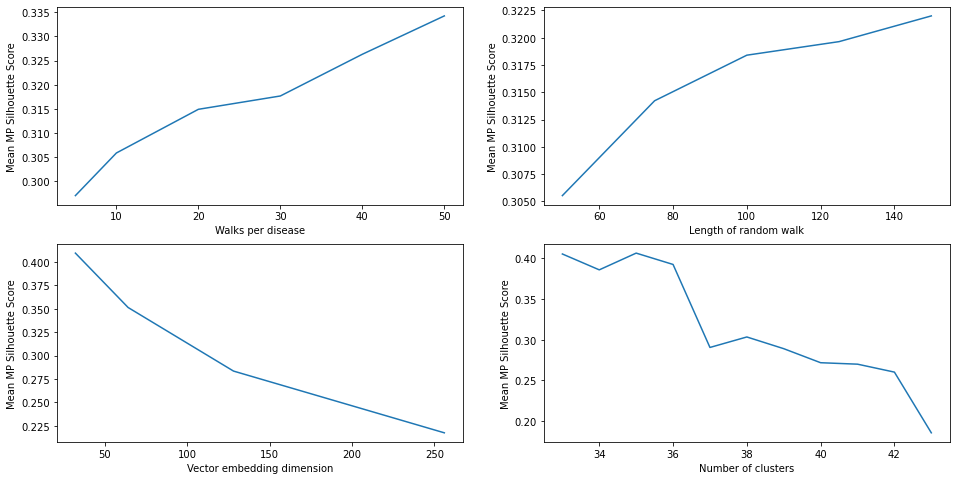

In [76]:
fig = plt.figure(figsize=(16, 8), facecolor='w', edgecolor='k')

plt.subplot(2,2,1)
plt.plot(model_eval_df.groupby('N_WALKS').silhouette_mutual_prox.agg('mean'))
plt.ylabel("Mean MP Silhouette Score")
plt.xlabel("Walks per disease")


plt.subplot(2,2,2)
plt.plot(model_eval_df.groupby('L_WALKS').silhouette_mutual_prox.agg('mean'))
plt.ylabel("Mean MP Silhouette Score")
plt.xlabel("Length of random walk")


plt.subplot(2,2,3)
plt.plot(model_eval_df.groupby('D_EMBED').silhouette_mutual_prox.agg('mean'))
plt.ylabel("Mean MP Silhouette Score")
plt.xlabel("Vector embedding dimension")


plt.subplot(2,2,4)
plt.plot(model_eval_df.groupby('K_clust').silhouette_mutual_prox.agg('mean'))
plt.ylabel("Mean MP Silhouette Score")
plt.xlabel("Number of clusters")


plt.show()

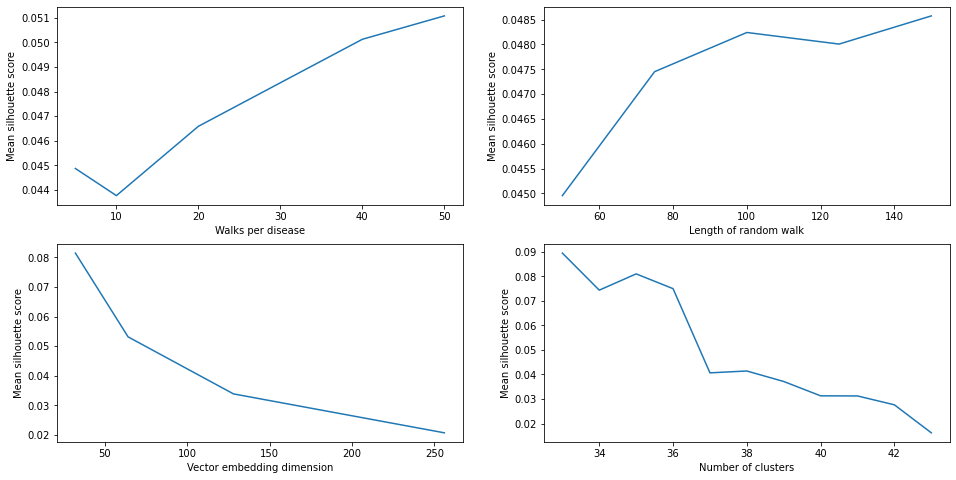

In [125]:
fig = plt.figure(figsize=(16, 8), facecolor='w', edgecolor='k')

plt.subplot(2,2,1)
plt.plot(model_eval_df.groupby('N_WALKS').silhouette_euclidean.agg('mean'))
plt.ylabel("Mean silhouette score")
plt.xlabel("Walks per disease")


plt.subplot(2,2,2)
plt.plot(model_eval_df.groupby('L_WALKS').silhouette_euclidean.agg('mean'))
plt.ylabel("Mean silhouette score")
plt.xlabel("Length of random walk")


plt.subplot(2,2,3)
plt.plot(model_eval_df.groupby('D_EMBED').silhouette_euclidean.agg('mean'))
plt.ylabel("Mean silhouette score")
plt.xlabel("Vector embedding dimension")


plt.subplot(2,2,4)
plt.plot(model_eval_df.groupby('K_clust').silhouette_euclidean.agg('mean'))
plt.ylabel("Mean silhouette score")
plt.xlabel("Number of clusters")


plt.show()

## Individual models

In [8]:
with open("../data/clusters/kmeans/ontograph_embed_N50_L150_D256_K14_KMEANS_KOPT40.pkl", 'rb') as f:
    high_dim_cluster = pickle.load(f)
    
with open("../data/clusters/kmeans/ontograph_embed_N50_L150_D32_K14_KMEANS_KOPT35.pkl", 'rb') as f:
    low_dim_cluster = pickle.load(f)

low_dim_f = "../data/embeddings/ontograph_embed_N50_L150_D32_K14.model"
low_dim_model = Word2Vec.load(low_dim_f)
low_dim_disease_vectors = low_dim_model.wv[diseases]
low_dim_standard_vectors = StandardScaler().fit_transform(low_dim_disease_vectors)
low_dim_normalized_vectors = Normalizer().fit_transform(low_dim_standard_vectors)

high_dim_f = "../data/embeddings/ontograph_embed_N50_L150_D256_K14.model"
high_dim_model = Word2Vec.load(high_dim_f)
high_dim_disease_vectors = high_dim_model.wv[diseases]
high_dim_standard_vectors = StandardScaler().fit_transform(high_dim_disease_vectors)
high_dim_normalized_vectors = Normalizer().fit_transform(high_dim_standard_vectors)


In [9]:
metrics.silhouette_score(low_dim_normalized_vectors, low_dim_cluster.labels_, metric='euclidean')

0.08938158

In [10]:
metrics.silhouette_score(high_dim_normalized_vectors, high_dim_cluster.labels_, metric='euclidean')

0.0260029

In [11]:
low_dist = metrics.pairwise_distances(low_dim_normalized_vectors)
high_dist = metrics.pairwise_distances(high_dim_normalized_vectors)

In [19]:
mp_dist_low = mutual_proximity_gauss(low_dist)
mp_dist_high = mutual_proximity_gauss(high_dist)

In [20]:
metrics.silhouette_score(mp_dist_low, low_dim_cluster.labels_, metric='precomputed')

0.42761046

In [21]:
metrics.silhouette_score(mp_dist_high, high_dim_cluster.labels_, metric='precomputed')

0.26585853

In [46]:
def goodman_kruskal_index(dist_m,labs)
    all_pairs = [i for i in combinations(range(dist_m.shape[0]),2)]
    Q_c = 0 
    Q_d = 0 
    for i in range(len(all_pairs)):
        for j in range(i+1,len(all_pairs)):
            same_class_i = (labs[all_pairs[i][0]] == labs[all_pairs[i][1]])
            same_class_j = (labs[all_pairs[j][0]] == labs[all_pairs[j][1]])

            dist_i = dist_m[all_pairs[i][0],all_pairs[i][1]]
            dist_j = dist_m[all_pairs[j][0],all_pairs[j][1]]

            if same_class_i and not same_class_j:
                if dist_i < dist_j:
                    Q_c += 1
                elif dist_i > dist_j:
                    Q_d += 1
            elif same_class_j and not same_class_i:
                if dist_j < dist_i:
                    Q_c += 1
                elif dist_j > dist_i:
                    Q_d += 1
    
    return (Q_c - Q_d)/(Q_c + Q_d)
            

KeyboardInterrupt: 